# AI Model for Stock Trade Recommendation

AI algorithms and models are around for quite some time now. I am curious to check how good they are in predicting stock prices. Are they any better in recommending SELL and BUY signals?

Stock trading community over the past decade has invented multiple technical analysis to predict stock price without worrying about underlying fundamentals and financials of the company. In a way, these technical analysis algorithms are like AI which could predict stock prices in the future. These algorithms are rule-based algorithms and could analyse based on a fixed set of relations only. On the other hand, ML and Deep Learning algorithms are devised to identify hidden complex patterns in data which are hard to identify and compute for a human mind.

By doing limited research (googling) on time series models I shortlisted three models:
* Prophet
* Long Short-Term Memory (LSTM)
* Convolutional Neural Network (CNN)

Across multiple articles, people mention that stock price prediction as one of the ideal use cases for LSTM but not many details on how good it is. I came across a paper "NSE Stock Market Prediction Using Deep-Learning Models" (https://www.sciencedirect.com/science/article/pii/S1877050918307828) which compares results from various models and concludes CNN is better than LSTM. Prophet model from Facebook seems like a new kid on the block and Facebook claims it is a much efficient model for time series prediction.

I decided to check out Prophet model first, primarily because a stock prediction library, Stocker, is readily available with this model. I had to make a few changes to 'Stocker' library for 'yahoo finance' data source and function parameters.

In this example, I am using "Asian Paints" stock price from NSE stock exchange. I am not just trying to predict the price in future, but to give out recommendations to BUY and SELL.


# Installs & Imports


The intiial [Stocker](https://https://github.com/WillKoehrsen/Data-Analysis/tree/master/stocker) module written by "Will Koehrsen" uses quandal as the data source. But the free BSE data feeds avilable in quandal are not adjusted to stock splits. I made minor modification to the code to fetch data from yahoo finance as well. 

I will be using [my version of Stocker](https://github.com/smurli/Data-Analysis/tree/master/stocker) and yahoo data feed for this exploration.

In [0]:
#Install packages
#!rm -rf DataAnalysis
!git clone https://github.com/smurli/Data-Analysis.git DataAnalysis
!pip install -U quandl numpy pandas fbprophet pytrends pystan pandas-datareader
!pip install seaborn==0.9.0
!pip install quandl 


In [0]:
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

#Hyper Parameters

##Stock Ticker
STOCK_TICKER = "ASIANPAINT.NS"

##Compare predictions of stock price starting from this year.
VALIDATE_FROM_YEAR = 2018

##Number of max trading days, as a safety measure. No matter what trade possition is closed after these many days.
MAX_TRADING_DAYS = 45

## Trading BUY/SELL threshold
UPPER_THRESHOLD = 0.05
LOWER_THRESHOLD = 0.02



# Load Data Set

In [0]:
from pandas_datareader import data as pddata
import datetime

start = datetime.datetime(2001, 1, 1)
end = datetime.date.today()
stock = pddata.DataReader(STOCK_TICKER, 'yahoo', start, end)
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-07-01,22.466999,21.367001,21.367001,22.287001,87810.0,1.595563
2002-07-02,22.783001,21.370001,21.370001,22.520000,588615.0,1.612244
2002-07-03,22.799999,21.933001,22.267000,22.733000,162075.0,1.627493
2002-07-04,23.333000,22.667000,22.667000,22.966999,266625.0,1.644245
2002-07-05,25.000000,23.333000,23.400000,24.056999,408600.0,1.722280


# Exploring price movement

Lets plot the price movement and volume variations in this stock in from 2016 years.

In this particular stock, we see the "Price Movement", fig 1, price dipped by late 2016, moved sideways in 2017 and goin through volatality in 2018. On volume data, fig 2, we see occational spike in volume and most of the time the volume traded are between 1M to 2M.

In the last 6 years, this stock has delived 260% profit. And in last 3 years this stock has delivered about 60% profit.


Text(0.5, 1.0, 'Volume Fluctuation (fig 4)')

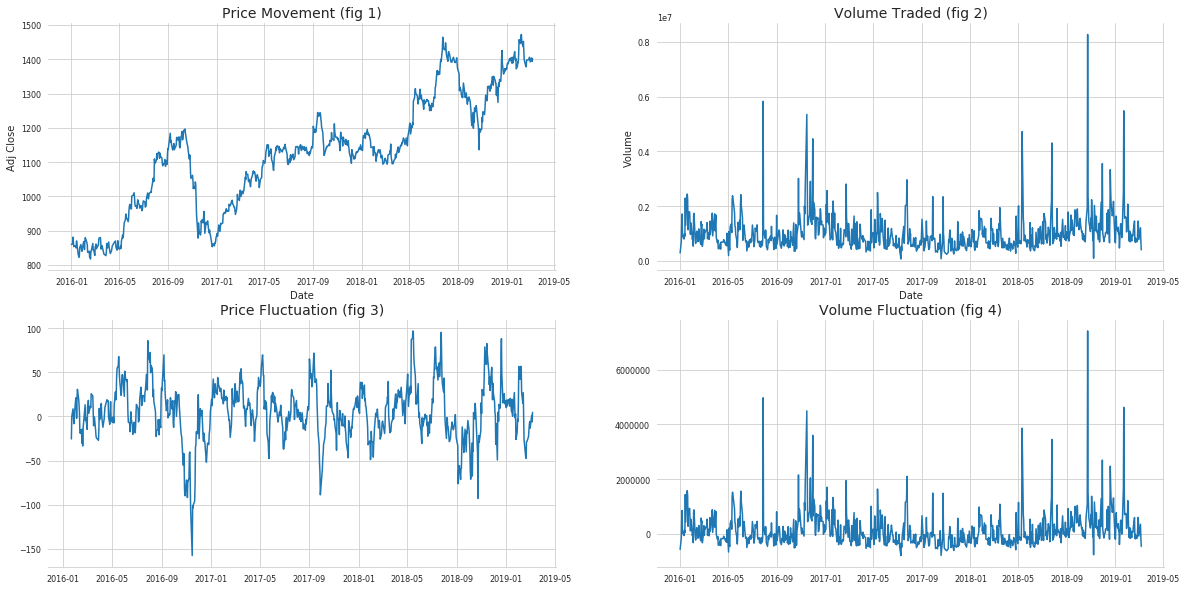

In [0]:
data = stock[stock.index.year>=2016]

fig, axarr = plt.subplots(2, 2, figsize=(20, 10))
sns.despine(left=True)

sns.lineplot(x=data.index,y=data["Adj Close"], ax=axarr[0][0]).set_title("Price Movement (fig 1)")
sns.lineplot(x=data.index,y=data["Volume"], ax=axarr[0][1]).set_title("Volume Traded (fig 2)")

#Rolling average
ma15 = data["Adj Close"].rolling(window=15).mean()
sns.lineplot(data=data["Adj Close"]-ma15, ax=axarr[1][0]).set_title("Price Fluctuation (fig 3)")


medianVol = data["Volume"].median()
sns.lineplot(data=data["Volume"] - medianVol,ax=axarr[1][1]).set_title("Volume Fluctuation (fig 4)")


# Load Test Data

In [0]:
data = stock[stock.index.year>=VALIDATE_FROM_YEAR]

# Setting Baselines

## Profit by Long Term Investment

If we have invested in this stock for a long term knowing that it will fair well for sure in the longer term, the following would be the total profit.

In [0]:
old = data.iloc[0]["Adj Close"]
new = data.iloc[-1]["Adj Close"]
print("Price at start of %d: %.2f, Price Today: %.2f " %(VALIDATE_FROM_YEAR, old, new))
print("Profit %%: %.2f" % (((new-old)/old)*100))


Price at start of 2018: 1135.55, Price Today: 1400.95 
Profit %: 23.37


## Profit by Time Machine

Lets say if have a time machine and using which we know exactly when the price will raise and fall. In such a case if we have invested in every possible BUY and sold at the correct SELL point, following would be the total profit. 

In [0]:
#%debug

def backFillNDays(df, nDays):
    col = "Profit"
    df[col] = 0
    #for i in tqdm_notebook(range(0,len(df.index)),desc=" "+str(nDays)+" Day Data Back Propogation"):
    for i in range(0,len(df.index)):
        x = df[i:i+nDays]
        maxPrice = x["Adj Close"].max()
        maxArg = x["Adj Close"].idxmax()
        df.loc[i,col] = maxPrice
        df.loc[i,col+"%"] = (maxPrice - df.loc[i,"Adj Close"])/(df.loc[i,"Adj Close"])
        df.loc[i,"DayToSell"] = df.loc[maxArg].Date

        
def timeMachineTrade(df, buy, sell):
    #for index, row in tqdm_notebook(data.iterrows(),total=data.shape[0]):
    position = "CLOSE"
    for i in range(0,len(df.index)):
        x = df[i:i+MAX_TRADING_DAYS]
        maxPrice = x["Adj Close"].max()
        maxArg = x["Adj Close"].idxmax()
        diff = (maxPrice - df.loc[i,"Adj Close"])/df.loc[i,"Adj Close"]
        if position == "CLOSE":
            if diff >= UPPER_THRESHOLD:
                #print (df.loc[i,"Date"], diff, "BUY")
                position = "OPEN"
                nofDays = 1
                buy.append(df.loc[i,"Date"])
        else:
            nofDays += 1
            if nofDays >= MAX_TRADING_DAYS:
                #print (df.loc[i,"Date"], diff, "SELL", "MAX_DAYS")
                nofDays = 0
                position = "CLOSE"
                sell.append(df.loc[i,"Date"])
            if diff <= LOWER_THRESHOLD:
                #print (df.loc[i,"Date"], diff, "SELL")
                nofDays = 0
                position = "CLOSE"
                sell.append(df.loc[i,"Date"])

                
def cumulativeProfit(data, buy, sell):
    total_pp = 0
    #for index, row in signal.iterrows():
    for i in range(0, len(buy)):    
        profit = data.loc[sell[i]].Close - data.loc[buy[i]].Close
        print("Buy on: {:%Y-%m-%d}, Sell on:{:%Y-%m-%d}, Profit: {:.2f}".format(buy[i], sell[i], profit))
        total_pp += profit/data.loc[buy[i]].Close
    return total_pp
        

tmData = data.copy()
tmData = tmData.reset_index()

buy = []
sell = []
timeMachineTrade(tmData, buy, sell)

# If sell signal is not yet generated for last buy, discard last buy signal
if len(buy) > len(sell):
    buy.pop()

p = cumulativeProfit(data, buy, sell)

print("Total Profit with time machine from year %s: %.2f" % (VALIDATE_FROM_YEAR, p*100))


Buy on: 2018-01-01, Sell on:2018-01-05, Profit: 41.60
Buy on: 2018-02-07, Sell on:2018-04-16, Profit: 57.75
Buy on: 2018-04-17, Sell on:2018-06-19, Profit: 93.20
Buy on: 2018-06-20, Sell on:2018-07-24, Profit: 196.45
Buy on: 2018-09-24, Sell on:2018-11-29, Profit: 78.35
Buy on: 2018-11-30, Sell on:2019-02-01, Profit: 111.25
Total Profit with time machine from year 2018: 46.59


# Profit by 'Prophet'

Lets see if we can device a model which would have got us better results than the "Profit by Long Term Investment" numbers and setting  "Profit by Time Machine" maximum extent.

We want to identify optimal BUY and SELL points for the stock so that, cumulative trade gives better returns. Its not just about beating long term investment, its about minimising the risk. Since the trade possition is held only n days max, the risk exposure it also minimised.


## Load Data Using Stocker

In [0]:
import quandl
from DataAnalysis.stocker.stocker import Stocker

#Fetch stock prices for Aisanpaints from yahoo
stock = Stocker(ticker = STOCK_TICKER, source='yahoo')
stock.stock.head()

ASIANPAINT.NS Stocker Initialized. Data covers 2002-07-01 to 2019-03-07.


,Date,High,Low,Open,Close,Volume,Adj Close,ds,Adj. Close,Adj. Open,y,Daily Change
0,2002-07-01,22.466999,21.367001,21.367001,22.287001,87810.0,1.595563,2002-07-01,22.287001,21.367001,22.287001,0.920000
1,2002-07-02,22.783001,21.370001,21.370001,22.520000,588615.0,1.612244,2002-07-02,22.520000,21.370001,22.520000,1.150000
2,2002-07-03,22.799999,21.933001,22.267000,22.733000,162075.0,1.627493,2002-07-03,22.733000,22.267000,22.733000,0.466000
3,2002-07-04,23.333000,22.667000,22.667000,22.966999,266625.0,1.644245,2002-07-04,22.966999,22.667000,22.966999,0.299999
4,2002-07-05,25.000000,23.333000,23.400000,24.056999,408600.0,1.722280,2002-07-05,24.056999,23.400000,24.056999,0.657000


## Data Exploration using Stocker
Stocker is a library written to predict the stock price using "phropet" model. This library also has a bunch of useful utilities for data exploration.



Lets plot the daily change in price and the daily volumn as a percentage relative to the average value.

In this stock we see, volume fluctuation is not much, but the variation of stock price in a day has biger range.

Maximum Daily Change = 55.60 on 2018-12-11.
Minimum Daily Change = -52.60 on 2018-10-09.
Current Daily Change = 2.20 on 2019-03-07.

Maximum Volume = 8272850.00 on 2018-10-23.
Minimum Volume = 100134.00 on 2018-11-07.
Current Volume = 404637.00 on 2019-03-07.



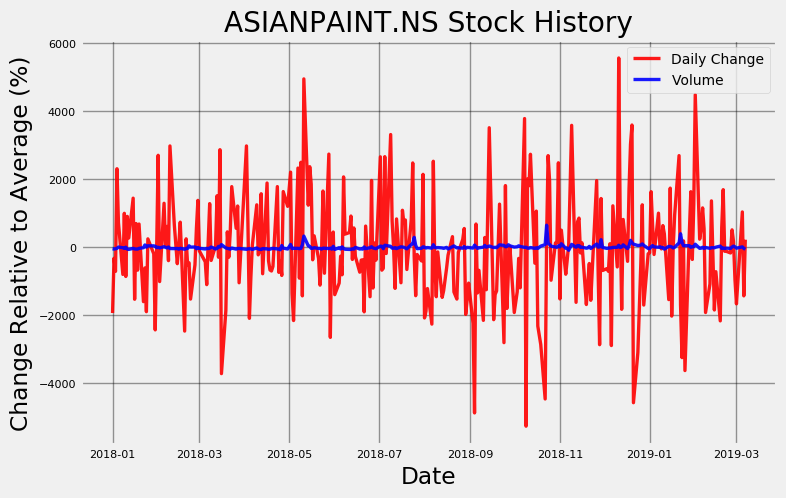

In [0]:
import datetime as dt


stock.plot_stock(start_date = '%s-01-01'%VALIDATE_FROM_YEAR, stats = ['Daily Change', 'Volume'], plot_type='pct')

Lets checkout trends and patters in the stock.

Most of the time stock price is with in the confidence interval and there are few case where the price moved out of the confidence band.

On the yearly trend we see, this stock do bad during November-January timeframe. This is expected as this is Paint related comany and painting work is slower during winter and rainly seasons.

Also surprisingly the stock price come down during the later part of the month, possibly due to option closure time frame?

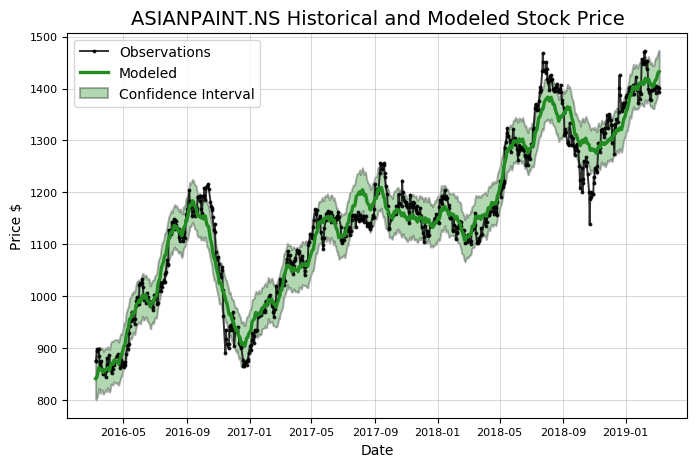

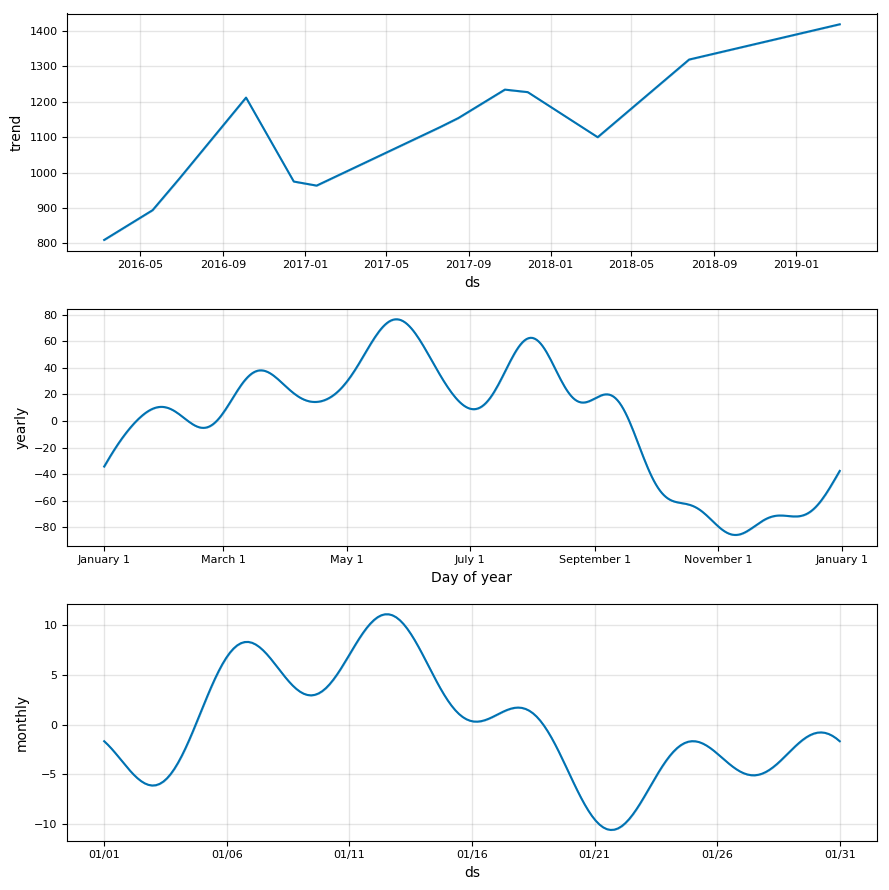

In [0]:
model, model_data = stock.create_prophet_model()
model.plot_components(model_data)
plt.show()

## Evaluate Prediction

From the prediction evaluation inbuilt in to Stocker, we see the absolute error on test data is very high. Lets try to tune the hyper parameters to get a better results on testing data.


Prediction Range: 2018-03-07 to 2019-03-07.

Predicted price on 2019-03-06 = $1127.47.
Actual price on    2019-03-06 = $1393.70.

Average Absolute Error on Training Data = $21.95.
Average Absolute Error on Testing  Data = $163.68.

When the model predicted an increase, the price increased 50.44% of the time.
When the model predicted a  decrease, the price decreased  53.38% of the time.

The actual value was within the 80% confidence interval 59.51% of the time.


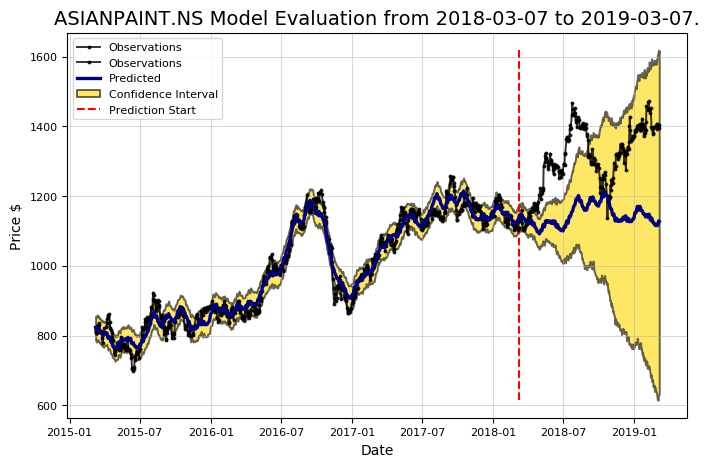

In [0]:
stock.evaluate_prediction()


## Changepoint Tuning


Validation Range 2017-03-07 to 2018-03-07.

       cps  train_err  train_range    test_err  test_range
0  0.00001  58.279355   142.536326   57.554304  141.931319
1  0.00010  57.177300   178.812409   51.574702  178.961211
2  0.00100  55.889353   183.108699   66.651108  182.858180
3  0.05000  28.486049    91.165337  281.106704  288.630495


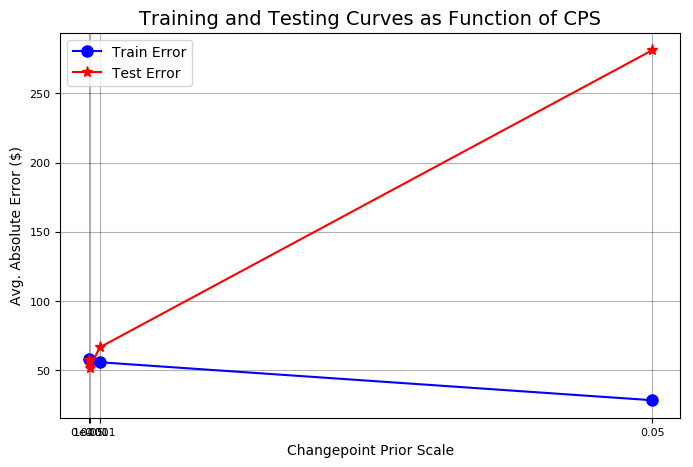

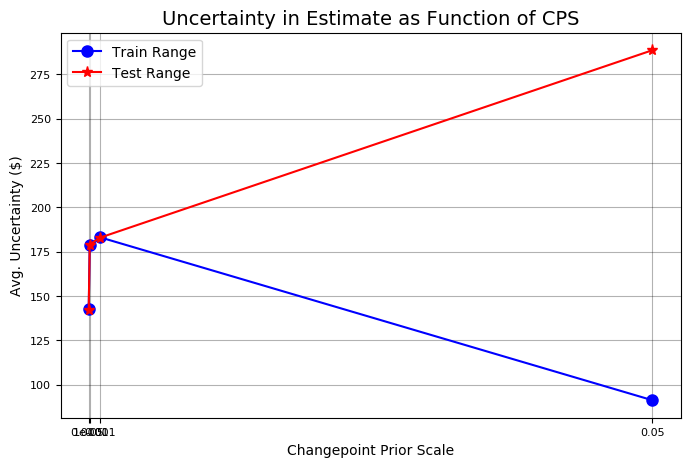

In [0]:
#stock.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])
stock.changepoint_prior_validation(changepoint_priors=[0.00001, 0.0001, 0.001, 0.05])


By Setting changepoint_prior_scale to 0.00010 for this stock, model seems to be giving better results compared to default values. The absolute error on testing data is arround Rs. 70, not a bad prediction. But the increase and decrese prediction is just about 50%, way below the expectation, it is as good a coin flip. So lets not use the direction to predict the BUY/SELL recomendation but rather use the price prediction for n days to make the call.



Prediction Range: 2018-03-07 to 2019-03-07.

Predicted price on 2019-03-06 = $1343.49.
Actual price on    2019-03-06 = $1393.70.

Average Absolute Error on Training Data = $41.72.
Average Absolute Error on Testing  Data = $70.93.

When the model predicted an increase, the price increased 51.59% of the time.
When the model predicted a  decrease, the price decreased  55.00% of the time.

The actual value was within the 80% confidence interval 48.18% of the time.


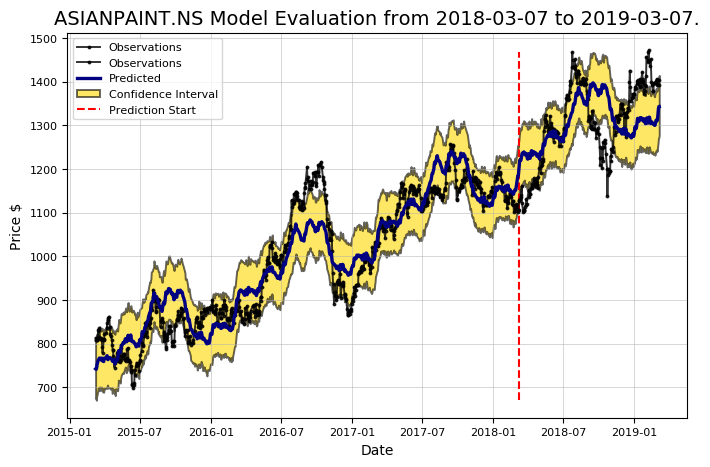

In [0]:
stock.max_date = max(stock.stock['Date'])
stock.changepoint_prior_scale = 0.00010
stock.evaluate_prediction()


## Predict BUY & SELL
Lets get BUY and SELL predictions based on price estimates from Prophet model for the next 'n' days.

In [0]:
testData = stock.stock.set_index("Date")
testData = testData[testData.index.year >= 2018]

UPPER_THRESHOLD = 0.05
LOWER_THRESHOLD = 0.02

position = "CLOSE"
nofDays = 0

buy = []
sell = []


for index, row in tqdm_notebook(testData.iterrows(),total=testData.shape[0]):
    stock.max_date = index
    ret = stock.predict_future(days=MAX_TRADING_DAYS, plot=False)
    maxEstimate = ret.estimate.max()
    
    diff = (maxEstimate - row["Adj Close"])/row["Adj Close"]
    if position == "CLOSE":
        if diff >= UPPER_THRESHOLD:
            print (index, diff, "BUY")
            position = "OPEN"
            nofDays = 1
            buy.append(index)
    else:
        nofDays += 1
        if nofDays >= MAX_TRADING_DAYS:
            print (index, diff, "SELL", "MAX_DAYS")
            nofDays = 0
            position = "CLOSE"
            sell.append(index)
        if diff <= LOWER_THRESHOLD:
            print (index, diff, "SELL")
            nofDays = 0
            position = "CLOSE"
            sell.append(index)


2018-01-02 00:00:00 0.056703075269687486 BUY
2018-01-09 00:00:00 0.017777265172849274 SELL
2018-01-24 00:00:00 0.060942347678320054 BUY
2018-02-05 00:00:00 0.013812549157377408 SELL
2018-02-06 00:00:00 0.06832000507334475 BUY
2018-04-13 00:00:00 0.12298526649498916 SELL MAX_DAYS
2018-04-16 00:00:00 0.09449730706258033 BUY
2018-06-18 00:00:00 0.18546066054544313 SELL MAX_DAYS
2018-06-19 00:00:00 0.13769252060804643 BUY
2018-07-18 00:00:00 0.013746857236780867 SELL
2018-09-03 00:00:00 0.055198916650167185 BUY
2018-11-09 00:00:00 0.05746658450375794 SELL MAX_DAYS
2018-11-12 00:00:00 0.09706468746363746 BUY
2018-11-20 00:00:00 0.019037513005436973 SELL



In [0]:
#def cumulativeProfit(data, buy, sell):
#    total_pp = 0
#    #for index, row in signal.iterrows():
#    for i in range(0, len(buy)):    
#        profit = data.loc[sell[i]].Close - data.loc[buy[i]].Close
#        print(buy[i], sell[i], profit)
#        total_pp += profit/data.loc[buy[i]].Close
#    return total_pp
        


# If sell signal is not yet generated for last buy, discard last buy signal
if len(buy) > len(sell):
    buy.pop()

p = cumulativeProfit(testData, buy, sell)
print(p*100)

Buy on: 2018-01-02, Sell on:2018-01-09, Profit: 50.30
Buy on: 2018-01-24, Sell on:2018-02-05, Profit: -16.95
Buy on: 2018-02-06, Sell on:2018-04-13, Profit: 51.95
Buy on: 2018-04-16, Sell on:2018-06-18, Profit: 103.20
Buy on: 2018-06-19, Sell on:2018-07-18, Profit: 123.80
Buy on: 2018-09-03, Sell on:2018-11-09, Profit: -66.00
Buy on: 2018-11-12, Sell on:2018-11-20, Profit: 28.05
23.462913123976044


# Conclusion
Using 'Prophet' to recommend BUY/SELL triggers, we would have got about 23% profit in the last year. This is effectively the returns we would have got from long term investment.

Even though this model doesn't fare any better than the long term investment, this would minimise the risk by reducing the exposure time. So there is some advantage from this model but not as compelling to take this recommendation any seriously.

Let's check out how other models fare for this data set.